# IMPORTS

In [19]:
import spacy
from spacy import displacy
from collections import Counter
from spacy import tokenizer
import nltk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

import io
import math
import requests
import PyPDF2
import spacy
import string
import re
import gensim
import glob
import os
from sklearn import svm
from sklearn import metrics

from sklearn.feature_extraction import text
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from pyLDA_visual import topic_visual
from Grid_Search_LDA import lda_gridsearch
from LDAGensim import lda_gensim_model

nlp = spacy.load('en_core_web_sm')

##nltk.download('words')
##nltk.download('punkt')
##nltk.download('maxent_ne_chunker')
##nltk.download('averaged_perceptron_tagger')
##nltk.download('state_union')##

# Utility methods

In [20]:
def get_org(doc):
    for i in doc.ents:
        if i.label_ == "ORG":
            organization = i.text
            return organization

In [21]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [22]:
def conf_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    labels=["no","yes"]
    hm = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels = labels)
    hm.set_xlabel("Predicted" , size =18)
    hm.set_ylabel("Actual", size =18)

In [23]:
def get_controversy_assessment(s,n):
    if s==0 and n==0:
        return 0
    if s==0 and n==1:
        return 1
    if s==0 and n==2:
        return 1
    if s==0 and n==3:
        return 1
    if s==1 and n==0:
        return 0
    if s==1 and n==1:
        return 1
    if s==1 and n==2:
        return 4
    if s==1 and n==3:
        return 4
    if s==2 and n==0:
        return 1
    if s==2 and n==1:
        return 4
    if s==2 and n==2:
        return 6
    if s==2 and n==3:
        return 6
    if s==3 and n==0:
        return 4
    if s==3 and n==1:
        return 4
    if s==3 and n==2:
        return 6
    if s==3 and n==3:
        return 6

In [24]:
def get_flag_colour(x):
    if x == 0:
        return "Red"
    if x ==1:
        return "Orange"
    if x > 1 and x < 5:
        return "Yellow"
    if x > 5:
        return "Green"

In [25]:
def get_subpillar(x):
    if x > 0 and x <= 7:
        return "Environment"
    if x > 7 and x <= 13:
        return "Customers"
    if x > 13 and x <= 17:
        return "Human rights and community"
    if x > 17 and x <= 24:
        return "Labour rights and supply chain"
    if x > 24:
        return "Governance"

In [26]:
def get_pillar(x):
    if x > 0 and x <= 7:
        return "Environment"
    if x > 7 and x <= 24:
        return "Social"
    if x > 24:
        return "Governance"

In [27]:
def get_status(x):
    if x == 0:
        return "Ongoing"
    if x == 1:
        return "Partially concluded"
    if x == 2:
        return "Concluded"

In [28]:
def get_involvment(x):
    if x == 0:
        return "Direct"
    if x == 1:
        return "Indirect"
    if x == 2:
        return "Concluded"

In [29]:
def get_scale(x):
    if x == 0:
        return "Very severe"
    if x == 1:
        return "Severe"
    if x == 2:
        return "Moderate"
    if x == 3:
        return "Minor"

In [30]:
def get_nature_of_impact(x):
    if x == 0:
        return "Very serious"
    if x == 1:
        return "Serious"
    if x == 2:
        return "Medium"
    if x == 3:
        return "Minimal"

In [31]:
def get_performance_indicator(x):
    if x == 0:
        return "Bio-diversit and land use"
    if x == 1:
        return "Toxic Emissiona and waste"
    if x == 2:
        return "Energy and climate change"
    if x == 3:
        return "Water stress"
    if x == 4:
        return "Operational waste(non-hazardous)"
    if x == 5:
        return "Supply chain management"
    if x == 6:
        return "Other-environment"
    if x == 7:
        return "Anti-competitive practices"
    if x == 8:
        return "Customer relations"
    if x == 9:
        return "Privacy and data security"
    if x == 10:
        return "Marketing and advertising"
    if x == 11:
        return "Product safety and quality"
    if x == 12:
        return "Other-customers"
    if x == 13:
        return "Impact on local communities"
    if x == 14:
        return "Human rights concers"
    if x == 15:
        return "Civil liberties"
    if x == 16:
        return "Other-human rights and communities"
    if x == 17:
        return "Labour management relations"
    if x == 18:
        return "Health and safety"
    if x == 19:
        return "Collective bargaining and Union"
    if x == 20:
        return "Discrimination and workforce diversity"
    if x == 21:
        return "Child labour"
    if x == 22:
        return "Supply chain labour standards"
    if x == 23:
        return "other-labour rights and supply chain"
    if x == 24:
        return "Bribery and fraud"
    if x == 25:
        return "Governance Structures"
    if x == 26:
        return "Contoversial investments"
    if x == 27:
        return "Other-governance"

In [32]:
def get_controversy_assessment_string(x):
    if x == 0:
        return "Very severe"
    if x == 1:
        return "Severe"
    if x == 4:
        return "Moderate"
    if x == 6:
        return "Minor"

In [33]:
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        print(f.read())

# Reading dataset

In [36]:
#os.chdir(r'./python_code')
path = './dataset.xlsx'
ds = pd.read_excel(path)

ds["SCALE"] = ds["SCALE"].fillna(0)
ds["NATURE_OF_HARM"] = ds["NATURE_OF_HARM"].fillna(0)

ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,1.0,4.0,0.0,0.0,NaN,NaN,NaN
1,Ecowas threatens tough sanctions on Guinea,Guinea-Ecowas-Transition-Sanctions Ecowas thre...,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,1.0,5.0,0.0,1.0,NaN,NaN,NaN
3,Siply Plans To Launch 1000 Phygital Branches R...,The company targets to launch 200 branches in ...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Denver judge rejects GOP residency complaint a...,A Democrat running to represent a state Senate...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Name of the Company

In [37]:
def get_company(ds):
    for index, x in ds.iterrows():
        temp = nlp(x["News"])
        ds.loc[index, "COMPANY_NAME"] = get_org(temp)
        if get_org(temp) == None :
            ds = ds.drop(index)
get_company(ds)
ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,1.0,4.0,0.0,0.0,AP,NaN,NaN
1,Ecowas threatens tough sanctions on Guinea,Guinea-Ecowas-Transition-Sanctions Ecowas thre...,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,the Economic Community of West African States,NaN,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,1.0,5.0,0.0,1.0,APA-Johannesburg (South Africa,NaN,NaN
3,Siply Plans To Launch 1000 Phygital Branches R...,The company targets to launch 200 branches in ...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Phygital,NaN,NaN
4,Denver judge rejects GOP residency complaint a...,A Democrat running to represent a state Senate...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Senate,NaN,NaN


# Data processing

In [38]:
stop_words = text.ENGLISH_STOP_WORDS
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=0, use_idf=True)


bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(ds.News)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names_out()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

# Plot top 10 ngrams
#plt.figure(figsize=(15, 5))
#plt.subplot(title='10 most common bi-grams')
#sns.barplot(x_pos, counts, palette='Blues_r')
#plt.xticks(x_pos, words, rotation=90)
#plt.xlabel('bi-grams')
#plt.ylabel('tfidf')
#plt.show()

# ESG relevant

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



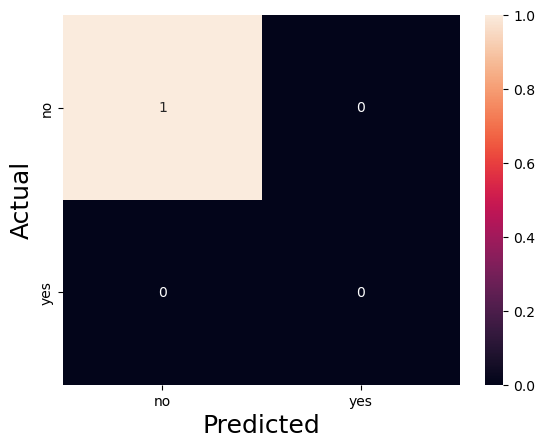

In [39]:
from sklearn.ensemble import RandomForestClassifier

word_tf_vectorizer = CountVectorizer(stop_words='english', max_df=0.95)
word_tf = word_tf_vectorizer.fit_transform(ds.News)

x_train5, x_test5, y_train5, y_test5 = train_test_split(word_tf, ds.ESG_RELEVANT, test_size=0.01, random_state=42)

model_rf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=10)
model_rf.fit(x_train5,y_train5)

y_pred5= model_rf.predict(x_test5)
print(metrics.classification_report(y_test5,y_pred5))
conf_matrix(y_test5, y_pred5)

In [40]:
for index, x in ds.iterrows():
    if x["ESG_RELEVANT"] == 0 :
        ds = ds.drop(index)
        
ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,1.0,4.0,0.0,0.0,AP,NaN,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,1.0,5.0,0.0,1.0,APA-Johannesburg (South Africa,NaN,NaN
5,CTâ€™s big hospital systems are buying up priv...,"Original reporting by Katy Golvala, Erica E. P...",1,28.0,1.0,2.0,2.0,5.0,0.0,1.0,Yale New Haven,NaN,NaN
6,Here are the Trump properties at the center of...,CNN â€”\n\nNew York Attorney General Letitia J...,1,25.0,3.0,2.0,2.0,5.0,0.0,0.0,CNN,NaN,NaN
8,Louisiana regulators approve 475 MW Entergy so...,SOLAR: Louisiana regulators approve four utili...,1,3.0,1.0,2.0,0.0,1.0,0.0,0.0,MW for Entergy,NaN,NaN


# LatentDirichletAllocation Model

In [41]:
word_tf_vectorizer = CountVectorizer(stop_words='english')
word_tf = word_tf_vectorizer.fit_transform(ds.News)

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=5,
                                      learning_decay=0.3,
                                      #max_iter=10,               # Max learning iterations
                                      #learning_method='online',
                                      random_state=42,          # Random state
                                      #batch_size=128,            # n docs in each learning iter
                                      #evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      #n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit(word_tf)

print(lda_model)
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(word_tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(word_tf))

# See model parameters
print(lda_model.get_params())

#print_top_words(lda_model, word_tf_vectorizer.get_feature_names(), 20)

LatentDirichletAllocation(learning_decay=0.3, n_components=5, random_state=42)
Log Likelihood:  -52225.7096611677
Perplexity:  1907.6306416523369
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.3, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [42]:
# %% Gensim LDA for coherence score
#lda_gensim_model(ds) #(stat_lem_list)
# No. of Topics = 9
# Human intution of topic names:
#TOPIC 1(G) : Ethical investment
#TOPIC 2(E): Sustainable finance
#TOPIC 3(S): Value employee
#TOPIC 4(G): Code of Conduct
#TOPIC 5(E): Climate change
#TOPIC 6(E): renewable energy
#TOPIC 7(G): Customer centric
#Topic 8(G): Strong governance
#Topic 9(S): Support community
#topic_names = [  'ethical investment',  'Sustainable finance',  'Value employee',  'Code of Conduct',  'Climate change','renewable energy','Customer centric','Strong governance','Support community']

topic_names = ['Environment',
               'Customers',
               'Human rights and community',
               'Labor rights and suppy chain',
               'Governance'
              ]

# Performance indicators classification

In [43]:
transformed = lda_model.transform(word_tf)
# find principal topic from distribution...
a = [topic_names[np.argmax(distribution)] for distribution in transformed]
# ... with associated probability
b = [np.max(distribution) for distribution in transformed]

esg_prob = pd.DataFrame(zip(a,b,transformed), columns=['SUB_PILLAR', 'probability', 'probabilities'])
ds["SUB_PILLAR"] = a

# Nature of harm classification

In [44]:
x_train, x_test, y_train, y_test = train_test_split(word_tf, ds.NATURE_OF_HARM, test_size=0.2, random_state=42)
model_svc = svm.LinearSVC(multi_class='crammer_singer')
model_svc.fit(x_train,y_train)

y_pred= model_svc.predict(x_test)
print(y_pred)

[1. 1. 1. 1.]


# Scale classification

In [45]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(word_tf, ds.SCALE, test_size=0.2, random_state=42)
model_svc2 = svm.LinearSVC(multi_class='crammer_singer')
model_svc2.fit(x_train2,y_train2)

y_pred2= model_svc2.predict(x_test2)
print(y_pred2)

[0. 1. 1. 1.]


# Status classification

In [46]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(word_tf, ds.STATUS, test_size=0.2, random_state=42)
model_svc3 = svm.LinearSVC(multi_class='crammer_singer')
model_svc3.fit(x_train3,y_train3)

y_pred3= model_svc3.predict(x_test3)
print(y_pred3)

[0. 0. 2. 0.]


# Involvement (Direct/Indirect)

In [47]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(word_tf, ds.INVOLVED, test_size=0.2, random_state=42)
model_svc4 = svm.LinearSVC(multi_class='crammer_singer')
model_svc4.fit(x_train4,y_train4)

y_pred4= model_svc4.predict(x_test4)
print(y_pred4)

[0. 0. 0. 0.]


# Controversy assessment and flag calculation

In [48]:
for index, x in ds.iterrows():
    ds.loc[index, "CONTROVERSY_ASSESSMENT"] = get_controversy_assessment(x["SCALE"],x["NATURE_OF_HARM"])

ds["FLAG"] = ds["CONTROVERSY_ASSESSMENT"] + ds["STATUS"] + ds["INVOLVED"]
ds["FLAG_SCORE"] = ds["FLAG"]
ds["name"] = ds["COMPANY_NAME"]

# Output processing

In [49]:
for index, x in ds.iterrows():
    ds.loc[index, "FLAG"] = get_flag_colour(x["FLAG"])
    ds.loc[index, "SUB_PILLAR"] = get_subpillar(x["PERFORMANCE_INDICATOR"])
    ds.loc[index, "PILLAR"] = get_pillar(x["PERFORMANCE_INDICATOR"])
    ds.loc[index, "STATUS"] = get_status(x["STATUS"])
    ds.loc[index, "INVOLVED"] = get_involvment(x["INVOLVED"])
    ds.loc[index, "SCALE"] = get_scale(x["SCALE"])
    ds.loc[index, "NATURE_OF_HARM"] = get_nature_of_impact(x["NATURE_OF_HARM"])
    ds.loc[index, "PERFORMANCE_INDICATOR"] = get_performance_indicator(x["PERFORMANCE_INDICATOR"])
    ds.loc[index, "CONTROVERSY_ASSESSMENT"] = get_controversy_assessment_string(x["CONTROVERSY_ASSESSMENT"])



In [50]:
ds.sort_values("COMPANY_NAME", ascending = False).head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG,FLAG_SCORE,name
5,CTâ€™s big hospital systems are buying up priv...,"Original reporting by Katy Golvala, Erica E. P...",1,None,Severe,Medium,Governance,Governance,Direct,Partially concluded,Yale New Haven,Moderate,None,5.0,Yale New Haven
9,"DeSANTIS DEFIANT: Gov Shreds Vineyard Lawsuit,...",Florida Governor Ron DeSantis has responded af...,1,Collective bargaining and Union,Severe,Serious,Social,Labour rights and supply chain,Direct,Partially concluded,The New York Post,Severe,Yellow,2.0,The New York Post
8,Louisiana regulators approve 475 MW Entergy so...,SOLAR: Louisiana regulators approve four utili...,1,Water stress,Severe,Medium,Environment,Environment,Direct,Ongoing,MW for Entergy,Moderate,Yellow,4.0,MW for Entergy
13,"Hyundai, Kia Sued in Rash of Car Thefts",Owners of Kia and Hyundai cars filed a class-a...,1,Other-customers,Very severe,Medium,Social,Customers,Direct,Partially concluded,Kia,Severe,Yellow,2.0,Kia
6,Here are the Trump properties at the center of...,CNN â€”\n\nNew York Attorney General Letitia J...,1,Governance Structures,Minor,Medium,Governance,Governance,Direct,Ongoing,CNN,Minor,Green,6.0,CNN


In [51]:
json = ds.drop(['News'], axis=1).to_json(orient ='records')

# Exporting result data

In [61]:
os.chdir(r'../src/app')
f = open("apiData.ts", "w")
f.write("export const dataList = ")
f.close()


f = open("apiData.ts", "a")
f.write(json)
f.close()

f = open("apiData.ts", "r")
print(f.read())
os.chdir(r'../../python_code')

export const dataList = [{"Title":"Home Depot workers petition to form 1st store-wide union","ESG_RELEVANT":1,"PERFORMANCE_INDICATOR":"Discrimination and workforce diversity","SCALE":"Severe","NATURE_OF_HARM":"Medium","PILLAR":"Social","SUB_PILLAR":"Labour rights and supply chain","INVOLVED":"Direct","STATUS":"Ongoing","COMPANY_NAME":"AP","CONTROVERSY_ASSESSMENT":"Moderate","FLAG":"Yellow","FLAG_SCORE":4.0,"name":"AP"},{"Title":"S\/African court freezes pension payment for graft-accused lottery chief","ESG_RELEVANT":1,"PERFORMANCE_INDICATOR":"Governance Structures","SCALE":"Severe","NATURE_OF_HARM":"Serious","PILLAR":"Governance","SUB_PILLAR":"Governance","INVOLVED":"Direct","STATUS":"Partially concluded","COMPANY_NAME":"APA-Johannesburg (South Africa","CONTROVERSY_ASSESSMENT":"Severe","FLAG":"Yellow","FLAG_SCORE":2.0,"name":"APA-Johannesburg (South Africa"},{"Title":"CT\u00e2\u20ac\u2122s big hospital systems are buying up private practices and small hospitals. What does that mean?","

# Read evaluation data

In [253]:
eval_ds = pd.DataFrame(columns=ds.columns)
eval_ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG,FLAG_SCORE,name


In [254]:
os.chdir(r'./evaluation_text')
my_files = glob.glob('*.txt')
for file in my_files:
    with open(file, 'r', encoding="utf8") as f:
        df_to_append = pd.DataFrame([f.read()], columns=['News'])
        eval_ds = eval_ds.append(df_to_append)
os.chdir(r'../')

C:\Users\admin\AppData\Local\Temp\ipykernel_8664\2872678757.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_ds = eval_ds.append(df_to_append)
C:\Users\admin\AppData\Local\Temp\ipykernel_8664\2872678757.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_ds = eval_ds.append(df_to_append)
C:\Users\admin\AppData\Local\Temp\ipykernel_8664\2872678757.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_ds = eval_ds.append(df_to_append)
C:\Users\admin\AppData\Local\Temp\ipykernel_8664\2872678757.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_ds = eval_ds.append(df_to_append)
C:\Users\admin\AppData\Local\Temp\ipyker

In [255]:
eval_ds

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG,FLAG_SCORE,name
0,NaN,"""The record-vying distributed denial-of-servic...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""The broadcasting of real money dice, roulette...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""LAHORE: Chief Minister Punjab Parvez Elahi on...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""The broadcasting of real money dice, roulette...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""ITANAGAR, 21 Sep: The state government has de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,"""â€œVegas is Vegas.â€\n\nArizona Cardinals qu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""â€œVegas is Vegas.â€\n\nArizona Cardinals qu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""â€œVegas is Vegas.â€\n\nArizona Cardinals qu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""â€œVegas is Vegas.â€\n\nArizona Cardinals qu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
word_tf2 = word_tf_vectorizer.transform(eval_ds.News)
yy= model_rf.predict(word_tf2)

ValueError: X has 3179 features, but RandomForestClassifier is expecting 2783 features as input.

In [178]:
eval_ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,PILLAR,SUB_PILLAR,INVOLVED,STATUS,COMPANY_NAME,CONTROVERSY_ASSESSMENT,FLAG
0,NaN,"""LAHORE: Chief Minister Punjab Parvez Elahi on...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""ITANAGAR, 21 Sep: The state government has de...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""The record-vying distributed denial-of-servic...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""â€œVegas is Vegas.â€\n\nArizona Cardinals qu...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,"""The broadcasting of real money dice, roulette...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
transformed2 = lda_model.transform(word_tf2)

# find principal topic from distribution...
a2 = [topic_names[np.argmax(distribution)] for distribution in transformed2]
# ... with associated probability
b2 = [np.max(distribution) for distribution in transformed2]

esg_prob2 = pd.DataFrame(zip(a2,b2,transformed2), columns=['SUB_PILLAR', 'probability', 'probabilities'])
eval_ds["SUB_PILLAR"] = a2

ValueError: X has 18235 features, but LatentDirichletAllocation is expecting 2783 features as input.

In [257]:
print(word_tf)

  (0, 1674)	1
  (0, 2739)	1
  (0, 263)	1
  (0, 1209)	7
  (0, 785)	5
  (0, 2719)	5
  (0, 1848)	1
  (0, 1038)	2
  (0, 1845)	4
  (0, 1022)	3
  (0, 1427)	4
  (0, 407)	3
  (0, 1073)	3
  (0, 2384)	4
  (0, 2703)	2
  (0, 2583)	2
  (0, 2722)	1
  (0, 1435)	1
  (0, 1269)	2
  (0, 2114)	1
  (0, 1653)	1
  (0, 2052)	1
  (0, 2695)	2
  (0, 2218)	1
  (0, 580)	1
  :	:
  (19, 1948)	1
  (19, 892)	1
  (19, 542)	1
  (19, 2037)	1
  (19, 1901)	1
  (19, 1756)	1
  (19, 1137)	1
  (19, 930)	1
  (19, 1130)	1
  (19, 2043)	1
  (19, 185)	2
  (19, 2499)	1
  (19, 128)	1
  (19, 2568)	1
  (19, 2296)	1
  (19, 1747)	1
  (19, 2167)	1
  (19, 757)	1
  (19, 1329)	1
  (19, 577)	1
  (19, 413)	1
  (19, 662)	1
  (19, 1900)	1
  (19, 148)	1
  (19, 1246)	1


In [258]:
print(word_tf2)

  (0, 0)	1
  (0, 3)	1
  (0, 14)	1
  (0, 15)	1
  (0, 17)	1
  (0, 60)	1
  (0, 91)	1
  (0, 95)	1
  (0, 101)	1
  (0, 115)	1
  (0, 116)	1
  (0, 167)	1
  (0, 168)	1
  (0, 175)	1
  (0, 176)	1
  (0, 189)	2
  (0, 197)	1
  (0, 235)	4
  (0, 239)	1
  (0, 261)	1
  (0, 303)	1
  (0, 319)	1
  (0, 325)	2
  (0, 342)	1
  (0, 362)	9
  :	:
  (64, 2642)	3
  (64, 2651)	1
  (64, 2685)	1
  (64, 2688)	1
  (64, 2699)	1
  (64, 2728)	1
  (64, 2733)	1
  (64, 2746)	1
  (64, 2747)	3
  (64, 2752)	1
  (64, 2875)	2
  (64, 2878)	1
  (64, 2894)	1
  (64, 2938)	1
  (64, 2942)	9
  (64, 2943)	1
  (64, 2944)	1
  (64, 2987)	1
  (64, 2997)	2
  (64, 3024)	1
  (64, 3025)	1
  (64, 3030)	1
  (64, 3083)	1
  (64, 3123)	2
  (64, 3152)	1
